In [1]:
# install packages
! pip install networkx==3.1
! pip install nxviz==0.7.3
! pip install pyvis==0.3.1

# load environment
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize, to_rgba
from networkx.algorithms.community import louvain_communities, modularity
from nxviz import CircosPlot
from nxviz.annotate import circos_group, circos_labels
from pyvis.network import Network

import glob
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
import numpy as np
import os
import pandas as pd
import random
import scipy
import seaborn as sns
import statistics

# set seed
np.random.seed(611)
random.seed(611)
random_state = np.random.RandomState(611)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


/usr/local/lib/python3.11/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
# define universal variables
COLOR = 'cornflowerblue'
CUTOFF_EFFECT_SIZE = 0.5
GROUP = 'control'
N_CORRELATIONS = 16851765
#N_CORRELATIONS = 63286875  # intra + interomics correlations
RESOLUTION = 0.45
SEED = 611

DTYPE_MAPPING={
    'col1': 'str',
    'name1': 'str',
    'type1': 'str',
    'supergroup1': 'str',
    'subgroup1': 'str',
    'col2': 'str', 
    'name2': 'str',
    'type2': 'str',
    'supergroup2': 'str',
    'subgroup2': 'str',
    'coef': 'float',
    'p-value': 'float',
    'pval_adj' : 'float'
}

In [3]:
# Remove previously generated webified partition graphs

# Specify the file pattern with a wildcard
file_pattern = '../output/{}/*.html'.format(GROUP)

# Get a list of file paths that match the pattern
file_paths = glob.glob(file_pattern)

# Delete each file
for file_path in file_paths:
    os.remove(file_path)

In [4]:
# define functions
def add_space_to_protein_name(n, t):
    if t == 'protein':
        return n + '°'
    return n


def determine_edge_color(value):
    value = float(value)
    if value > 0:
        return (65,105,225)  # royal blue
    if value < 0:
        return (220,20,60)  # crimson
    return (105,105,105)  # dimgrey


def define_node_color(type):
    if type == 'metabolite': 
        return 'mediumorchid'
    if type == 'miRNA': 
        return 'palepink'
    if type == 'protein':
        return 'seagreen'
    if type == 'transcript':
        return 'cornflowerblue'
    if type == 'histopathology':
        return 'goldenrod'
    return 'dimgrey'


def create_node_type_lists(name, t, list_histopathology, list_metabolites, list_mirna,\
                           list_proteins, list_transcripts):
    if t == 'histopathology':
        list_histopathology.append(name)
    elif t == 'metabolite':
        list_metabolites.append(name)
    elif t == 'miRNA':
        list_mirnas.append(name)
    elif t == 'protein':
        list_proteins.append(name)
    elif t == 'transcript':
        list_transcripts.append(name)
    return(list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts)


def add_node_info(row, nodes, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts):
    name1 = add_space_to_protein_name(row['name1'], row['type1'])
    name2 = add_space_to_protein_name(row['name2'], row['type2'])
    if name1 not in nodes:
        nodes.append(name1)
        color = define_node_color(row['type1'])
        list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts \
        = create_node_type_lists(name1, row['type1'], list_histopathology, list_metabolites,\
                                 list_mirnas, list_proteins, list_transcripts)
    if name2 not in nodes:
        nodes.append(name2)
        color = define_node_color(row['type2'])
        list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts \
        = create_node_type_lists(name2, row['type2'], list_histopathology, list_metabolites,\
                                 list_mirnas, list_proteins, list_transcripts)
    return(nodes, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts)

    
def add_n_of_x_to_list(l, n, x):
    c = 0
    while c < n:
        l.append(x)
        c += 1
    return l


def print_list(l):
    for item in l:
        print(item)

        
def print_community_by_node_type(community, list_histopathology, list_metabolites, list_mirans,\
                                 list_proteins, list_transcripts):
    list_temp_metabolites = []
    list_temp_mirnas = []
    list_temp_placental_features = []
    list_temp_proteins = []
    list_temp_transcripts = []
    for item in community:
        if item in list_histopathology:
            list_temp_placental_features.append(item)
        elif item in list_metabolites:
            list_temp_metabolites.append(item)
        elif item in list_mirnas:
            list_temp_mirnas.append(item)
        elif item in list_proteins:
            list_temp_proteins.append(item)
        elif item in list_transcripts:
            list_temp_transcripts.append(item)
        else:
            print("Error! Unidentified node type: " + item)
    print('Placental Histopathological Features: ')
    print_list(sorted(list_temp_placental_features))
    print('\nMetabolites:')
    print_list(sorted(list_temp_metabolites))
    print('\nmiRNAs:')
    print_list(sorted(list_temp_mirnas))
    print('\nProteins:')
    print_list(sorted(list_temp_proteins))
    print('\nTranscripts:')
    print_list(sorted(list_temp_transcripts))

        
def print_communities(communities, list_histopathology, list_metabolites, list_mirnas,\
                      list_proteins, list_transcripts):
    count = 0
    for community in communities:
        print('Community ' + str(count))
        print_community_by_node_type(community, list_histopathology, list_metabolites,\
                                     list_mirnas, list_proteins, list_transcripts)
        print('\n\n\n')
        count += 1
        
        
def initialize_dict(l):
    d = {}
    for item in l:
        d[item] = 0
    return d


def limit_to_n_top_correlations_per_group(df, col, list_of_groups, n, ascending=False):
    d = initialize_dict(list_of_groups)
    df_final = pd.DataFrame(columns=df.columns)
    
    df = df.reindex(df[col].abs().sort_values(ascending=ascending).index)
    print('The', col, 'of', str(n), 'top selected nodes:')
    for index, row in df.iterrows():
        type1 = row['type1']
        type2 = row['type2']
        if type1 == type2:
             continue
        if d[type1] < n or d[type2] < n:
            print(abs(row[col]))
            df_final.loc[len(df_final.index)] = row
            d[type1] += 1
            d[type2] +=1
    print(d)
    return df_final


def make_color_map(Gsub, centrality):
    color_map = []

    # Make color map
    color_map = [centrality[n] for n in Gsub.nodes()]
    minima = min(color_map)
    maxima = max(color_map)
    norm = Normalize(vmin=minima, vmax=maxima)

    # Use rainbow colormap
    cmap = cm.viridis
    node_colors = [cmap(norm(centrality[node])) for node in Gsub.nodes]
    
    # Create a ScalarMappable with the provided normalization and colormap
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    mapper.set_array([])

    return node_colors, mapper


def plot_and_save_colorbar(mapper, file_path):
    fig, ax = plt.subplots()
    cbar = ColorbarBase(ax, cmap=mapper.cmap, norm=mapper.norm, orientation='vertical')
    plt.savefig(file_path)
    plt.close()

        
def rgba_to_hex(rgba):
    r, g, b, a = rgba
    hex_color = "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))
    return hex_color


def rgb_to_hex(rgb):
    r, g, b = rgb
    hex_color = "#{:02X}{:02X}{:02X}".format(int(r), int(g), int(b))
    return hex_color


def generate_pyvis_object(Gsub, node_colors, count, extension):
    # Create a Pyvis Network object for each community
    pyvisG = Network(height='1500px', notebook=False)
    for node, color in zip(Gsub.nodes, node_colors):
        color = rgba_to_hex(color)
        pyvisG.add_node(node, color=color, inherit_colors=False)
    for edge in Gsub.edges:
        target, source = edge
        color = Gsub[target][source]['color']
        color = rgb_to_hex(color)
        pyvisG.add_edge(target, source, color=color, inherit_colors=False)

    # Save the Pyvis object to an HTML file
    pyvisG.show('../output/{}/{}community{}_sig_edges_resolution{}.html'.format(GROUP,\
                                                                                extension,\
                                                                                count,\
                                                                                RESOLUTION))
    pyvisG.toggle_physics(False)
    pyvisG.show('../output/{}/{}community{}_sig_edges_resolution{}_physics_off.html'.format(GROUP,\
                                                                                            extension,\
                                                                                            count,\
                                                                                            RESOLUTION))


def plot_subgraphs(comm1, extension=''):
    for count, c in enumerate(comm1):
        if len(c) >= 10:
            
            # Create a subgraph for the community
            Gsub = G.subgraph(c)

            # Calculate closeness centrality for each node in the subgraph
            centrality = nx.closeness_centrality(Gsub)

            # Make color map
            node_colors, mapper = make_color_map(Gsub, centrality)

            # save color bar
            colorbar_filepath = '../output/{}/{}community{}_color_bar.pdf'.format(GROUP, extension, count)
            plot_and_save_colorbar(mapper, colorbar_filepath)

            # Create a Pyvis Network object for each community
            generate_pyvis_object(Gsub, node_colors, count, extension)
            

def build_attribute_map(nodes, dictionary):
    attributeMap = []
    for n in nodes:
        attributeMap.append(dictionary[n])
    return(attributeMap)


def convert_percent_to_float(n):
    # Ensure that 
    if n < 0 or n > 100:
        print('Error! Cutoff for displaying labels for top percentage of nodes based on centrality must be provided as a percentage (0-100) or a float (0-1)')
        return 0
    if n > 0 and n < 1:
        return n
    return float(n/100)


def generate_index(n, list_length):
    if n*list_length < 1:
        return list_length
    return int(n*list_length)


def check_end(n, color_key, list_nodes):
    for node in list_nodes[n:]:
        last_node = list_nodes[n-1]
        if color_key[node] == color_key[last_node]:
            n+=1
        else:
            return n
    return n


def print_top_centrality_nodes(l, color_key):
    for item in l:
        print(item + ':', round(color_key[item], 5))


def identify_highest_centrality_nodes(S, color_key, n):
    # Get nodes with the top n% centrality in each community
    
    # initiate entities
    community_nodes = list(S.nodes())
    community_centrality = {node: color_key[node] for node in community_nodes}
    
    # make sure n is a float between 0 and 1 and that at least one node will be selected
    n = convert_percent_to_float(n)
    n = generate_index(n, len(community_nodes))

    # Sort nodes by centrality and select the top nodes
    sorted_nodes = sorted(community_centrality, key=community_centrality.get, reverse=True)
    n = check_end(n, color_key, sorted_nodes)
    top_nodes = sorted_nodes[:n]
    print_top_centrality_nodes(top_nodes, color_key)
    
    # make dict containing names of top nodes only, otherwise hold node place as blank string
    top_centrality_nodes = {node: node if node in top_nodes else '' for node in S.nodes()}

    return top_centrality_nodes


def make_centrality_plot(S, color_key, file_name, percent_labeled):
    # Get the nodes with the highest centrality
    top_centrality_nodes = identify_highest_centrality_nodes(S, color_key, percent_labeled)
    
    # initiate plot
    fig, ax = plt.subplots()

    # make color map
    color_map = [color_key[n] for n in S.nodes()]
    minima = min(color_map)
    maxima = max(color_map)
    norm = plt.Normalize(vmin=minima, vmax=maxima)

    # Use rainbow colormap
    cmap = cm.rainbow

    # Create a ScalarMappable with the provided normalization and colormap
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    mapper.set_array([])

    # Draw all nodes with colors based on centrality, labeling only top nodes
    nx.draw(S, pos=nx.spring_layout(S, seed=SEED), node_color=color_map, cmap=cmap,\
            labels=top_centrality_nodes, with_labels=True, ax=ax)

    # Add colorbar using the ScalarMappable
    cbar = plt.colorbar(mapper, ax=ax)

    # plot and save
    plt.savefig(file_name)
    plt.axis('off')
    plt.show()


def plot_centrality(G, comm1, file_prefix, percent_labeled=0.02):
    color_map = []
    color_key = {}
    count_c = 0
    for community in comm1:
        if len(community) >= 10:
            print('Community', count_c)
            subgraph = G.subgraph(community)
            centrality = nx.closeness_centrality(subgraph)
        else:
            count_c += 1
            continue
        for n in subgraph.nodes():
            color_key[n] = centrality[n]
        for c in sorted(nx.connected_components(subgraph), key=len, reverse=True):
            c = list(c)
            sub_nodes = list(nx.node_connected_component(subgraph, c[0]))
            S = G.subgraph(sub_nodes)
            dict_relabel_subset = {}
            file_name = '../output/' + GROUP + '/' + file_prefix + str(count_c) + '.pdf'
            make_centrality_plot(S, color_key, file_name, percent_labeled)
            count_c += 1
        

def print_sorted_dict(d, reverse=True):
    sorted_dict = sorted(d.items(), key=lambda x:x[1], reverse=reverse)
    for node, value in sorted_dict:
        value = round(value, 5)
        print(node + ':', value)
        
        
def calc_network_efficiency(comm1):    
    count_c = 0
    for community in comm1:
        if len(community) >= 10:
            print('Community', count_c)
            subgraph = G.subgraph(community) 
            esize = nx.effective_size(subgraph)
            efficiency = {n: v / subgraph.degree(n) for n, v in esize.items()}
            print_sorted_dict(efficiency, reverse=False)
            print('\n')
        count_c+=1
        

def perform_louvain_community_analysis_on_communities(G, comm, list_histopathology, list_metabolites,\
                                                      list_mirnas, list_proteins, list_transcripts):
    dict_modularity = {}
    for count, c in enumerate(comm1):
        if len(c) >= 10:
            comm2 = louvain_communities(G.subgraph(comm[count]), weight='coef', seed=SEED, resolution=RESOLUTION)
            mod = round(modularity(G.subgraph(c), comm2, weight='coef', resolution=RESOLUTION), 3)
            dict_modularity['Community ' + str(count)] = mod
            print('Community', count, 'Modularity:', mod)
            print_communities(comm2, list_histopathology, list_metabolites, list_mirnas, list_proteins,\
                              list_transcripts)
            print('Community Sub-Coummunities', count, 'Closeness Centrality')
            extension = 'community' + str(count) + '_'
            plot_subgraphs(comm2, extension=extension)
            print('Community Sub-Communities', count, 'Network Efficiencies')
            calc_network_efficiency(comm2)
            print('\n\n\n')
    return dict_modularity


def get_community_node_info(count, c, G, df_comm):
    # Prepare data to be appended
    data_to_append = []
    
    # Create a subgraph for the community
    Gsub = G.subgraph(c)
    
    # Calculate closeness centrality for each node in the subgraph
    centrality = nx.closeness_centrality(Gsub)
    
    # Normalize centrality scores to be on a scale of 0 to 1
    centrality_scores = [centrality[n] for n in Gsub.nodes()]
    minima = min(centrality_scores)
    maxima = max(centrality_scores)
    norm = Normalize(vmin=minima, vmax=maxima)

    # Append each node's data to the DataFrame
    for node, cent_score in centrality.items():
        
        # Add each node's data as a dictionary to the list
        analyte_type = Gsub.nodes[node]['type']  # get type from node attributes
        
        # remove ° symbol from protein node names
        if analyte_type == 'protein':
            name = node[:-1]
        else:
            name = node
            
        # store info for the node to append to the df
        data_to_append.append({
            'Community': count,
            'Analyte Name': name,
            'Analyte Type': analyte_type,
            'Closeness Centrality Score': round(norm(cent_score), 4)
        })

    # Concatenate the new data with the existing DataFrame
    df_comm = pd.concat([df_comm, pd.DataFrame(data_to_append)], ignore_index=True)
    
    return df_comm


def make_centrality_df(GROUP, G, comm1):
    # Define the column names
    columns = ['Community', 'Analyte Name', 'Analyte Type', 'Closeness Centrality Score']
    # Create an empty DataFrame with the specified columns
    df_comm = pd.DataFrame(columns=columns)
    
    # Save centrality scores following community detection
    for count, c in enumerate(comm1):
        df_comm = get_community_node_info(count, c, G, df_comm)
    
    # Save community centrality values to CSV
    df_comm.to_csv('../output/' + GROUP + '/' + GROUP + '_communities_and_closeness_centrality_scores.csv', index=False)
    
    return df_comm

In [5]:
# load data
df = pd.read_csv('../../spearman_correlations/interomics/' + GROUP + '/spearman.standardized.interomics.' + GROUP + '.all.miniDP3.txt', sep='\t', dtype=DTYPE_MAPPING)
df = df[df['type1'] != df['type2']]
df = df[df['p-value']<0.05/N_CORRELATIONS]
print('Number of significant correlations:', str(df.shape[0]))

Number of significant correlations: 2267


Number of significant correlations passing effect size cutoff: 2267


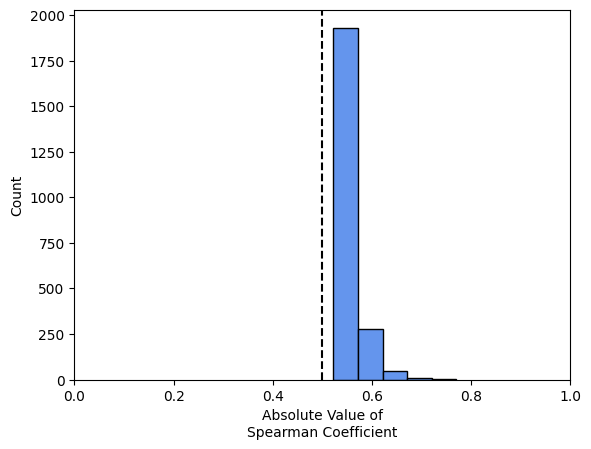

In [6]:
# make histogram of spearman coefficients
list_coef = list(abs(df['coef']))
n_bins = round((max(list_coef) - min(list_coef))/0.05)  # calculate number of bins
abs(df['coef']).plot.hist(bins=n_bins, color=COLOR, edgecolor='black')
plt.axvline(x=CUTOFF_EFFECT_SIZE, color='black', linestyle='dashed')
plt.xlabel('Absolute Value of\nSpearman Coefficient')
plt.ylabel('Count')
plt.xlim(0, 1)

 # Save Plot
plt.savefig('../output/'+ GROUP + '/spearman.standardized.interomics.' + GROUP + '.coef.histogram.pdf', bbox_inches='tight')

# filter for effect size
df = df[abs(df['coef']) >= CUTOFF_EFFECT_SIZE]
print('Number of significant correlations passing effect size cutoff:', str(df.shape[0]))

In [7]:
# identify the top 50 correlations by datatype
list_analytes = ['histopathology', 'metabolite', 'miRNA', 'protein', 'transcript']
df_most_important = limit_to_n_top_correlations_per_group(df, 'p-value', list_analytes, 50, ascending=True)


# format data for network
colormap = {'histopathology': 'goldenrod', 'metabolite': 'mediumorchid', 'miRNA': 'palepink', 'protein': 'seagreen', 'transcript': 'cornflowerblue'}
dict_edge_color = {}
dict_edge_weight = {}
dict_node_color = {}
dict_node_type = {}
dict_nodes_by_type = {'histopathology': [], 'metabolite': [], 'miRNA': [], 'protein': [], 'transcript': []}
edges = set()
list_histopathology = []
list_metabolites = []
list_mirnas = []
list_node_color = []
list_proteins = []
list_transcripts = []
nodes_initial = []
nodes = []

for index, row in df_most_important.iterrows():
    name1 = add_space_to_protein_name(row['name1'], row['type1'])
    name2 = add_space_to_protein_name(row['name2'], row['type2'])
    key = (name1, name2)
    edges.add(key)
    dict_edge_color[key] = determine_edge_color(row['coef'])
    dict_edge_weight[key] = abs(row['coef'])
    
    nodes_initial, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts \
    = add_node_info(row, nodes_initial, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts)
    dict_node_color[name1] = colormap[row['type1']]
    dict_node_color[name2] = colormap[row['type2']]
    dict_node_type[name1] = row['type1']
    dict_node_type[name2] = row['type2']
    dict_nodes_by_type[row['type1']].append(name1)
    dict_nodes_by_type[row['type2']].append(name2)
    
    edges.add(key)


# sort nodes list by type
for key, value in dict_nodes_by_type.items():
    value = sorted(list(set(value)))    # add alphabetically sorted nodes
    #value = list(set(value))
    nodes.extend(value)
    color = colormap[key]    # add node color to list
    list_node_color = add_n_of_x_to_list(list_node_color, len(value), color)
   
    
# initiate network
G = nx.Graph()
G.add_nodes_from(nodes)
nx.set_node_attributes(G, dict_node_type, name="type")
for edge in edges:
    G.add_edge(*edge, weight=math.sqrt(math.sqrt(dict_edge_weight[edge])), color=dict_edge_color[edge])

print(len(nodes))
print(len(edges))

The p-value of 50 top selected nodes:
2.0003580871232787e-23
3.221159953183693e-22
5.962321322717246e-21
9.265370313500866e-19
1.189257662918041e-18
4.275262488045255e-18
4.909967573871584e-18
1.7184730683399405e-17
2.1780923833848617e-17
1.2865740655279652e-16
1.4744859054047416e-16
2.389338018856099e-16
4.200195751664447e-16
6.733626740477698e-16
1.3503398510567936e-15
3.73472096002292e-15
5.6140103238041285e-15
6.199524362816643e-15
7.591956396570285e-15
7.840877608066954e-15
9.475489323416664e-15
1.0475011518655819e-14
1.2290563218350301e-14
1.2719603773521868e-14
1.7555659349201727e-14
1.99202866380752e-14
2.6225526229044527e-14
2.723849632939568e-14
3.6195438993544184e-14
3.924450647369887e-14
4.1407764321698546e-14
4.3901865345439716e-14
4.618997986552064e-14
4.9138666703555374e-14
4.94529523474424e-14
5.069700518874042e-14
5.522177092430506e-14
5.6591336078165413e-14
6.128880784002496e-14
6.352592348163297e-14
6.579885832026894e-14
6.938058042468602e-14
8.73085853701291e-14
9.1

/usr/local/lib/python3.11/site-packages/nxviz/api.py:275: UserWarning: As of nxviz 0.7, the object-oriented API is being deprecated in favour of a functional API. Please consider switching your plotting code! The object-oriented API wrappers remains in place to help you transition over. A few changes between the old and new API exist; please consult the nxviz documentation for more information. When the 1.0 release of nxviz happens, the object-oriented API will be dropped entirely.
  warnings.warn(


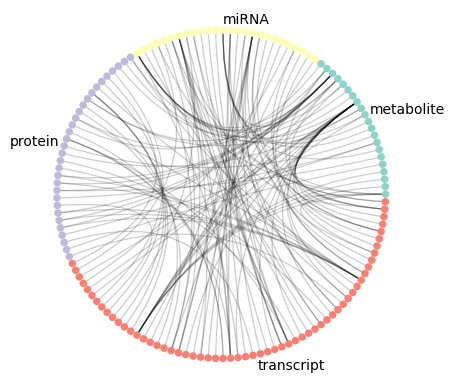

In [8]:
# CircosPlot(G, node_color='type', edge_color='color', edge_width='weight')
CircosPlot(G, node_color='type', edge_width='weight')
circos_group(G, group_by='type')
plt.savefig('../output/'+ GROUP + '/spearman.standardized.interomics.' + GROUP + '.50.most.sig.by.dataset.network.pdf', bbox_inches='tight')

/usr/local/lib/python3.11/site-packages/nxviz/api.py:275: UserWarning: As of nxviz 0.7, the object-oriented API is being deprecated in favour of a functional API. Please consider switching your plotting code! The object-oriented API wrappers remains in place to help you transition over. A few changes between the old and new API exist; please consult the nxviz documentation for more information. When the 1.0 release of nxviz happens, the object-oriented API will be dropped entirely.
  warnings.warn(


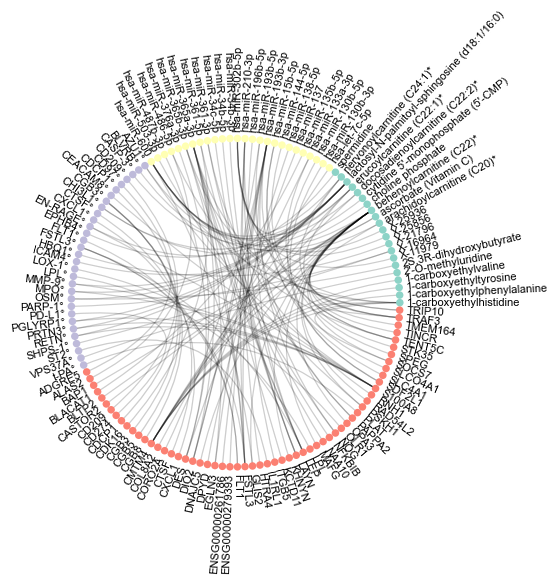

In [9]:
# CircosPlot(G, node_color='type', edge_color='color', edge_width='weight')
CircosPlot(G, node_color='type', edge_width='weight')
circos_labels(G, layout='rotate', fontdict={'family': 'Arial', 'size': 8})
plt.savefig('../output/'+ GROUP + '/spearman.standardized.interomics.' + GROUP + '.50.most.effect.by.dataset.network.labels.pdf', bbox_inches='tight')

In [10]:
for node in G.nodes():
    print(node)

1-carboxyethylhistidine
1-carboxyethylphenylalanine
1-carboxyethyltyrosine
1-carboxyethylvaline
2'-O-methyluridine
2S,3R-dihydroxybutyrate
X-11979
X-16964
X-21796
X-25856
X-25936
arachidoylcarnitine (C20)*
ascorbate (Vitamin C)
behenoylcarnitine (C22)*
choline phosphate
cytidine 5'-monophosphate (5'-CMP)
docosadienoylcarnitine (C22:2)*
erucoylcarnitine (C22:1)*
lactosyl-N-palmitoyl-sphingosine (d18:1/16:0)
nervonoylcarnitine (C24:1)*
spermidine
hsa-let-7c-5p
hsa-miR-130b-3p
hsa-miR-130b-5p
hsa-miR-133a-3p
hsa-miR-135b-5p
hsa-miR-137
hsa-miR-138-5p
hsa-miR-144-5p
hsa-miR-15b-5p
hsa-miR-193b-3p
hsa-miR-193b-5p
hsa-miR-196b-5p
hsa-miR-210-3p
hsa-miR-302b-5p
hsa-miR-34b-3p
hsa-miR-34b-5p
hsa-miR-34c-5p
hsa-miR-361-3p
hsa-miR-361-5p
hsa-miR-365a-3p
hsa-miR-365b-3p
hsa-miR-376a-3p
hsa-miR-486-5p
hsa-miR-487b-3p
hsa-miR-503-3p
hsa-miR-600
AZU1°
BLVRB°
CASP-3°
CD209°
CD97°
CDCP1°
CEACAM8°
CGB3°
CHI3L1°
CTSF°
CXCL1°
EN-RAGE°
EPHB4°
FLT1°
FSTL3°
HBQ1°
ICAM4°
LOX-1°
LPL°
MMP-9°
MPO°
OSM°
PARP-1°


In [11]:
# load data
df = pd.read_csv('../../spearman_correlations/interomics/' + GROUP + '/spearman.standardized.interomics.' + GROUP + '.all.miniDP3.txt', sep='\t', dtype=DTYPE_MAPPING)
df = df[df['type1'] != df['type2']]
df = df[df['p-value']<0.05/N_CORRELATIONS]
df = df[abs(df['coef']) >= CUTOFF_EFFECT_SIZE] 


# format data for network
colormap = {'histopathology': 'goldenrod', 'metabolite': 'mediumorchid', 'miRNA': 'palepink', 'protein': 'seagreen', 'transcript': 'cornflowerblue'}
dict_edge_color = {}
dict_edge_weight = {}
dict_node_type = {}
dict_nodes_by_type = {'histopathology': [], 'metabolite': [], 'miRNA': [], 'protein': [], 'transcript': []}
edges = set()
list_histopathology = []
list_metabolites = []
list_mirnas = []
list_node_color = []
list_proteins = []
list_transcripts = []
nodes_initial = []
nodes = []

for index, row in df.iterrows():
    name1 = add_space_to_protein_name(row['name1'], row['type1'])
    name2 = add_space_to_protein_name(row['name2'], row['type2'])
    key = (name1, name2)
    edges.add(key)
    dict_edge_color[key] = determine_edge_color(row['coef'])
    dict_edge_weight[key] = abs(row['coef'])
    
    nodes_initial, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts \
    = add_node_info(row, nodes_initial, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts)
    dict_node_color[name1] = colormap[row['type1']]
    dict_node_color[name2] = colormap[row['type2']]
    dict_node_type[name1] = row['type1']
    dict_node_type[name2] = row['type2']
    dict_nodes_by_type[row['type1']].append(name1)
    dict_nodes_by_type[row['type2']].append(name2)
    
    edges.add(key)

    
# sort nodes list by type
for key, value in dict_nodes_by_type.items():
    value = sorted(list(set(value)))    # add alphabetically sorted nodes
    nodes.extend(value)
    color = colormap[key]    # add node color to list
    list_node_color = add_n_of_x_to_list(list_node_color, len(value), color)
    
    
# initiate network
G = nx.Graph()
G.add_nodes_from(nodes, node_color=list_node_color)
nx.set_node_attributes(G, dict_node_type, name="type")
for edge in edges:
    G.add_edge(*edge, weight=math.sqrt(math.sqrt(dict_edge_weight[edge])), color=dict_edge_color[edge])

    
# save as graph object
nx.write_gml(G, '../output/{}/sig_edges.gml'.format(GROUP))


print('Number of Nodes:', str(len(nodes)))
print('Number of Edges:', str(len(edges)))

Number of Nodes: 1137
Number of Edges: 2267


In [12]:
comm1 = louvain_communities(G, weight='coef', resolution=RESOLUTION, seed=SEED)
print("Number of communites formed from pairwise comparisons: " + str(len(comm1)))

# Save the graph with community structure to a file
nx.write_gml(G, '../output/{}/community_structure.sig_edges.gml'.format(GROUP))

# print all communities
print_communities(comm1, list_histopathology, list_metabolites, list_mirnas, list_proteins, list_transcripts)

Number of communites formed from pairwise comparisons: 38
Community 0
Placental Histopathological Features: 

Metabolites:
S-methylcysteine

miRNAs:

Proteins:

Transcripts:
ERRFI1




Community 1
Placental Histopathological Features: 

Metabolites:
X-16964

miRNAs:

Proteins:
PARP-1°
SHPS-1°

Transcripts:




Community 2
Placental Histopathological Features: 

Metabolites:
ascorbate (Vitamin C)

miRNAs:

Proteins:
BLVRB°
ICAM4°

Transcripts:




Community 3
Placental Histopathological Features: 

Metabolites:
cytidine 5'-monophosphate (5'-CMP)

miRNAs:

Proteins:
CASP-3°

Transcripts:




Community 4
Placental Histopathological Features: 

Metabolites:
2S,3R-dihydroxybutyrate
choline phosphate
lactosyl-N-palmitoyl-sphingosine (d18:1/16:0)

miRNAs:

Proteins:
AZU1°
CEACAM8°
CHI3L1°
EN-RAGE°
MMP-9°
MPO°
OSM°
PGLYRP1°
PRTN3°
RETN°

Transcripts:
S100A8




Community 5
Placental Histopathological Features: 

Metabolites:

miRNAs:
hsa-miR-126-3p

Proteins:

Transcripts:
BST2
MFNG




Commun

Number of communites formed from pairwise comparisons: 38
Number of communites with community sizes >= 10: 8
Percentage of nodes in 10+ communities: 93.66754617414249
Modularity: 0.8

Community Size Stats

Min Community Size: 2
Max Community Size: 554
Median Community Size: 2.0
IQR of Community Size: 2.0
Mean Community Size: 29.92105263157895
Standard Deviation of Community Size: 93.33936384026443

Community 10+ Size Stats

Min Community Size: 14
Max Community Size: 554
Median Community Size: 90.0
IQR of Community Size: 65.25
Mean Community Size: 133.125
Standard Deviation of Community Size: 175.01382598444698


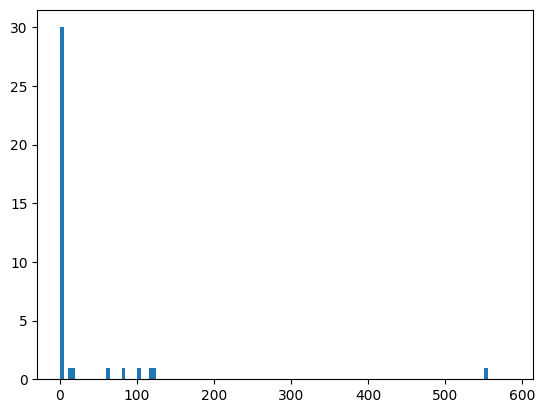

(array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
        220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
        275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
        330., 335., 340., 345.

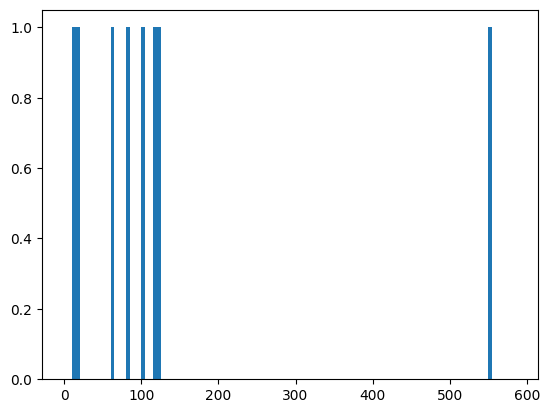

In [13]:
# evaluate community size
comm_sizes = []
comm_10_sizes = []

for c in comm1:   
    comm_sizes.append(len(c))
    if (len(c)>=10):
        comm_10_sizes.append(len(c))
        
# print statistics about community sizes
print("Number of communites formed from pairwise comparisons:", str(len(comm_sizes)))
print("Number of communites with community sizes >= 10:", str(len(comm_10_sizes)))
print('Percentage of nodes in 10+ communities:', str(100*sum(comm_10_sizes)/sum(comm_sizes)))
print('Modularity:', str(round(modularity(G, comm1, weight='coef', resolution=RESOLUTION),2)))
print('\nCommunity Size Stats\n')
print('Min Community Size:', str(min(comm_sizes)))
print('Max Community Size:', str(max(comm_sizes)))
print('Median Community Size:', str(statistics.median(comm_sizes)))
print('IQR of Community Size:', str(scipy.stats.iqr(comm_sizes)))
print('Mean Community Size:', str(statistics.mean(comm_sizes)))
if len(comm_sizes) > 1:
    print('Standard Deviation of Community Size:', str(statistics.stdev(comm_sizes)))
print('\nCommunity 10+ Size Stats\n')
print('Min Community Size:', str(min(comm_10_sizes)))
print('Max Community Size:', str(max(comm_10_sizes)))
print('Median Community Size:', str(statistics.median(comm_10_sizes)))
print('IQR of Community Size:', str(scipy.stats.iqr(comm_10_sizes)))
print('Mean Community Size:', str(statistics.mean(comm_10_sizes)))
if len(comm_10_sizes) > 1:
    print('Standard Deviation of Community Size:', str(statistics.stdev(comm_10_sizes)))

# plot community size histograms
binwidth=5
plt.hist(comm_sizes, range=[0, int(max(comm_sizes)*1.05)], bins=range(0, int(max(comm_sizes)*1.05) + binwidth, binwidth))
plt.show()
plt.clf()
plt.hist(comm_10_sizes, range=[0, int(max(comm_10_sizes)*1.05)], bins=range(0, int(max(comm_10_sizes)*1.05) + binwidth, binwidth))

In [14]:
# save centrality data to csv
make_centrality_df(GROUP, G, comm1)

# plot pyvis subgraphs with the node color indicating closeness centrality value
plot_subgraphs(comm1)